# Plot Process Local Reliability Analysis (Mean Value method)

A reliability analysis is performed using 1, 2 and 3 uncertain parameters. The range of the uncertain parameters is adjusted from their standard values to include the solution point in different ways.

In [2]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

## 1 Uncertain Parameter

Attempt a local reliability analysis with just `fimp_14` uncertain.

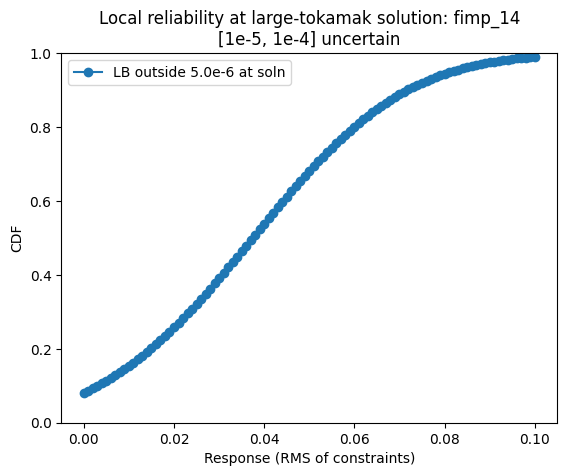

In [3]:
def read_ra_data(results_file: str) -> np.ndarray:
    """Read in Dakota reliability analysis results file.

    Parameters
    ----------
    results_file : str
        file to read in

    Returns
    -------
    np.ndarray
        Results in array format
    """
    # Read in output file
    output_filename = Path(results_file)
    with open(output_filename, "r") as output_file:
        for line_no, line_str in enumerate(output_file.readlines()):
            if "Cumulative Distribution Function (CDF)" in line_str:
                start = line_no + 3
            elif "Iterator local_reliability completed" in line_str:
                finish = line_no - 2

    return np.loadtxt(output_filename, skiprows=start, max_rows=(finish - start))


# Read in reliability analysis data
ra_data = read_ra_data("mv_1p_outside_soln_results.txt")
fig, ax = plt.subplots()
ax.plot(ra_data[:, 0], ra_data[:, 1], marker="o", label="LB outside 5.0e-6 at soln")
ax.set_xlabel("Response (RMS of constraints)")
ax.set_ylabel("CDF")
ax.set_title(
    "Local reliability at large-tokamak solution: fimp_14\n[1e-5, 1e-4] uncertain"
)
ax.set_ylim(0.0, 1.0)
ax.legend()
# plt.axvline(x=0, color="black", linestyle="--")
# plt.axhline(y=0.2, color="black", linestyle="--")

Despite the uncertainty interval for parameter `fimp_14` being outside the value at the solution point, the CDF is >0 for an RMS of constraints of 0: the design is feasible for some uncertain values, and hence has >0 reliability. But why is the CDF never 0? Perhaps some negative values?

Try extending the uncertain interval to include the solution point:

## Including solution point in uncertain parameter range

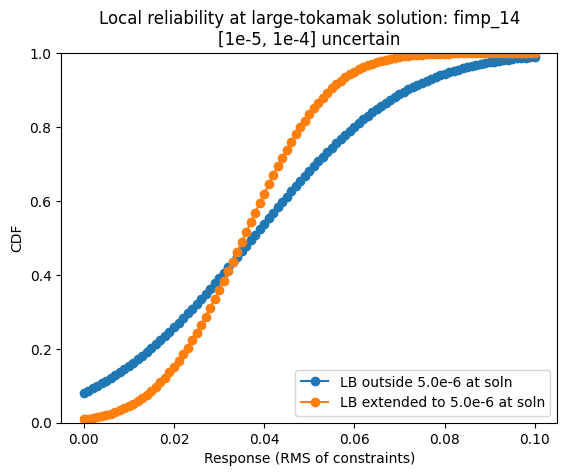

In [4]:
ra_data = read_ra_data("mv_1p_results.txt")
ax.plot(ra_data[:, 0], ra_data[:, 1], marker="o", label="LB extended to 5.0e-6 at soln")
ax.legend()
fig

When the lower bound is extended to include the solution point, the CDF is actually lower for the 0 RMS of constraints (feasible) case. This implies that the probability of being feasible (i.e. reliability) is in fact lower when the solution point is included in the bounds of the uncertain parameter, which doesn't make sense. But perhaps this is due to the bounds being larger than before?

Try shifting the bounds to include the solution point, rather than extending them:

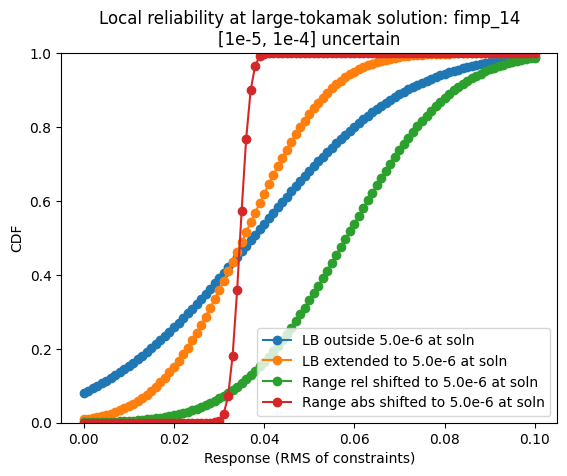

In [5]:
ra_data = read_ra_data("mv_1p_shifted_rel_results.txt")
ax.plot(
    ra_data[:, 0],
    ra_data[:, 1],
    marker="o",
    label="Range rel shifted to 5.0e-6 at soln",
)
ra_data = read_ra_data("mv_1p_shifted_abs_results.txt")
ax.plot(
    ra_data[:, 0],
    ra_data[:, 1],
    marker="o",
    label="Range abs shifted to 5.0e-6 at soln",
)
ax.legend()
fig

How should the uncertain bounds be modified to include the solution point?

Some confusing results: absolutely shifting the bounds of the uncertain parameter to include the solution point, hence maintaining the range of the parameter, results in the sharp red curve. This shows 0 reliability (CDF = 0 until constraints = 0.03), despite the solution point being included in the uncertain range. Indeed, the reliability (CDF when constraints = 0) is worse than when the LB is outside the solution point (blue curve).

Why has the variance decreased so much in red case? The range of uncertainty is the same as the blue curve. Confusing.

Relatively shifting the range (green curve) results in lower reliability, despite including the solution point and having a lower range (4.5e-5). Also confusing.

## Multiple uncertain parameters

Add 3 uncertain parameters and see what the effect on reliability is. 3 most influential parameters from SOFE poster.

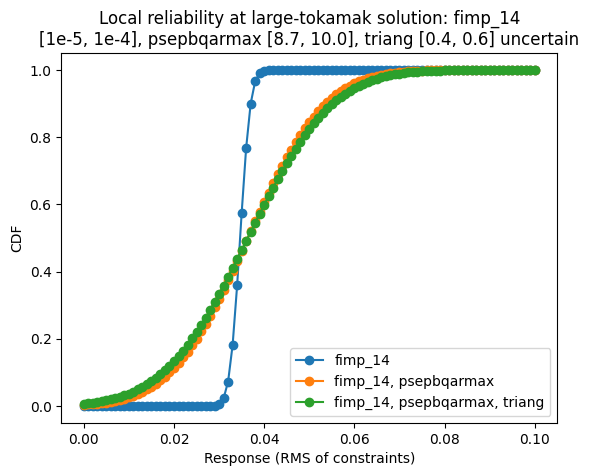

In [6]:
# Read in reliability analysis data
# Read in 1 parameter again
ra_data = read_ra_data("mv_1p_shifted_abs_results.txt")

fig, ax = plt.subplots()
ax.plot(ra_data[:, 0], ra_data[:, 1], marker="o", label="fimp_14")
ax.set_xlabel("Response (RMS of constraints)")
ax.set_ylabel("CDF")
ax.set_title(
    "Local reliability at large-tokamak solution: fimp_14\n[1e-5, 1e-4], psepbqarmax [8.7, 10.0], triang [0.4, 0.6] uncertain"
)

# 2 parameters
ra_data = read_ra_data("mv_2p_results.txt")
ax.plot(
    ra_data[:, 0],
    ra_data[:, 1],
    marker="o",
    label="fimp_14, psepbqarmax",
)

# 3 parameters
ra_data = read_ra_data("mv_3p_results.txt")
ax.plot(
    ra_data[:, 0],
    ra_data[:, 1],
    marker="o",
    label="fimp_14, psepbqarmax, triang",
)
ax.legend()

More uncertain params produces a greater variance in infeasibility, which makes sense. fimp_14 produces very narrow variance, however; would expect wider as most influential param. Adding more uncertain parameters appears to improve the severity function (higher CDF for lower severity than in the 1 param case), which doesn't make sense: more uncertainties improve the reliability.

These observations don't appear to make much intuitive sense: this could be due to the cheap mean value (MV) approximation method. It might be worth running similar studies using Monte Carlo methods to see if there are any differences that might help explain these observations.